A neural network for modal verb sense classification. [The MSC corpus](https://doi.org/10.11588/data/JEESIQ) collection tagged with three types of modal sense classes for English modal verbs: can, must, may, should, and could. The data is already processed altogether with the sentences, modal tags, and modal verbs.

In [47]:
import pandas as pd
import seaborn as sns
from google.colab import files
import io
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%tensorflow_version 2.x # tensorflow magic, only to be used in google colab. comment out if using other editor/environment
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dense, Activation, Dropout, Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from tensorflow.keras import optimizers, regularizers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # tensorflow magic, only to be used in google colab. comment out if using other editor/environment`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [48]:
# uploading the dataset
data = files.upload()

Saving masc_data.csv to masc_data (1).csv


In [49]:
# loading the data into panda dataframe
df = pd.read_csv(io.BytesIO(data['masc_data.csv']), names=['sent', 'mtag', 'mverb'], sep=',', encoding="utf8",header=1)

Looking into the data

In [50]:
df.head()

,sent,mtag,mverb
0,So that raises an issue for us because clearly...,dy,could
1,And I wanted to let you go as far as you could...,dy,could
2,But I was as clear as I could possibly be that...,dy,could
3,That could be one of the most unhappy experien...,ep,could
4,We could only hope not .,dy,could


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1794 entries, 0 to 1793
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sent    1794 non-null   object
 1   mtag    1794 non-null   object
 2   mverb   1794 non-null   object
dtypes: object(3)
memory usage: 42.2+ KB


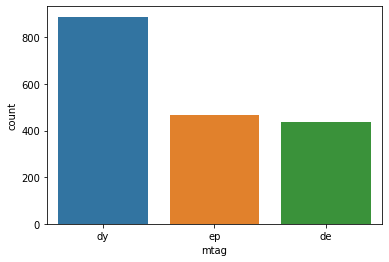

In [52]:
sns.countplot(x=df.mtag)

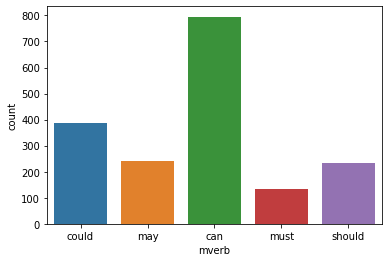

In [53]:
sns.countplot(x=df.mverb)

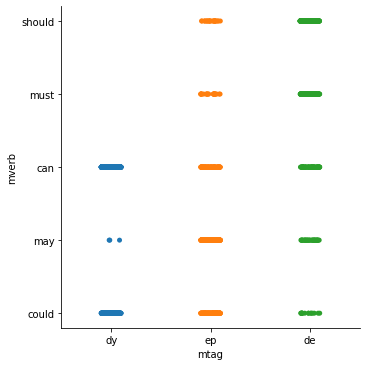

In [54]:
sns.catplot(x="mtag", y="mverb", data=df)

In [55]:
groupby_mverb = df.groupby(['mverb','mtag'])
display(groupby_mverb.count())

sent
mverb  mtag      
can    de      68
       dy     647
       ep      80
could  de      16
       dy     238
       ep     133
may    de      38
       dy       3
       ep     202
must   de     107
       ep      27
should de     209
       ep      26

In [56]:
groupby_mtag = df.groupby(['mtag','mverb'])
display(groupby_mtag.count())

sent
mtag mverb       
de   can       68
     could     16
     may       38
     must     107
     should   209
dy   can      647
     could    238
     may        3
ep   can       80
     could    133
     may      202
     must      27
     should    26

Data Preprocessing.

The following codes are modified version of cf. Germies (2020). The original code can be found [here](https://github.com/codeblonde/ModalSenseClassification/blob/master/MSCBinaryTSMS.ipynb).

In [57]:
# function to remove any special characters like punctuation, integer and other symbols
def clean(texts):
  cleanTexts = []
  for sent in texts:
    #remove punctuation, integer and other symbols
    stripped = [w for w in sent.split() if w.isalpha()] 
    # join the remaining alphabet characters with whitespace
    stripped = ' '.join(stripped)
    cleanTexts.append(stripped)
  return cleanTexts

In [58]:
# Encoding Texts into Word Embeddings
# Flair Word Embeddings
!pip install flair
from flair.embeddings import WordEmbeddings
from flair.data import Sentence

def embed(cleanTexts):
  # loading english word embeddings
  embeddings = WordEmbeddings('en')
  embeddedSents = []
  for text in cleanTexts:
    sent = Sentence(text)
    # transform each sentence into word vector sequence
    embeddings.embed(sent) 
    embeddedSents.append([t.embedding.numpy() for t in sent])
  return embeddedSents

In [59]:
# Padding
def pad(embeddedSents):
  #200 pad embeddings to have same length
  padded = pad_sequences(embeddedSents, padding= 'post', dtype='float32', truncating = 'post', maxlen = 100)
  return padded

In [60]:
# one-hot-encoding of the labels
def encode_y(labels):
  label_encoder = LabelEncoder()
  # transform string labels into integers
  int_encoded = label_encoder.fit_transform(labels) 
  # transform integers into n-dimensional one-hot encodings
  onehot_encoded = to_categorical(array(int_encoded)) 
  return onehot_encoded

In [61]:
# converting into list to apply the functions defined above
df_sent = df.sent.tolist()
df_mtag = df.mtag.tolist()
df_mverb = df.mverb.tolist()

In [62]:
cleaned_sent = clean(df_sent)

In [63]:
embedded_sent = embed(cleaned_sent)

In [64]:
xtrain = pad(embedded_sent)

In [65]:
xtrain

array([[[ 5.130e-02, -1.780e-02, -1.370e-02, ...,  1.444e-01,
          1.421e-01, -1.330e-02],
        [ 8.060e-02, -6.300e-03,  8.750e-02, ...,  2.192e-01,
          1.880e-02, -6.080e-02],
        [ 4.570e-02,  1.010e-02,  1.489e-01, ...,  1.437e-01,
          1.941e-01, -1.035e-01],
        ...,
        [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00,
          0.000e+00,  0.000e+00],
        [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00,
          0.000e+00,  0.000e+00],
        [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00,
          0.000e+00,  0.000e+00]],

       [[ 1.100e-02, -4.600e-02, -5.050e-02, ...,  1.380e-02,
          5.900e-02,  4.860e-02],
        [-1.457e-01,  9.500e-02,  4.090e-02, ...,  2.813e-01,
          1.541e-01, -7.620e-02],
        [ 2.810e-02, -1.092e-01,  9.470e-02, ...,  1.505e-01,
          1.007e-01,  6.310e-02],
        ...,
        [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00,
          0.000e+00,  0.000e+00],
        [ 0.

In [66]:
# encoding the labels
ytrain = encode_y(df_mtag)

In [67]:
ytrain

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [68]:
# train-test split
x_train, x_val, y_train, y_val = train_test_split(xtrain, ytrain, test_size = 0.2, random_state= 42)

Defining the Model

This is a modified version of Germies' model

In [69]:
def define_model(length, dims): #sequence length, vocab size/embedding dims
  # channel 1
  inputs1 = Input(shape=(length, dims))
  conv1 = Conv1D(filters = 128, kernel_size = 4, activation = 'relu', activity_regularizer=regularizers.l2(0.001))(inputs1)#(embedding1) #filter size 4
  drop1 = Dropout(0.5)(conv1) # higher drop out = slower and more consistent learning
  pool1 = MaxPooling1D(pool_size = 2)(drop1)
  flat1 = Flatten()(pool1)
  # channel 2
  inputs2 = Input(shape=(length, dims))
  conv2 = Conv1D(filters = 128, kernel_size = 6, activation = 'relu', activity_regularizer=regularizers.l2(0.001))(inputs2)#(embedding2) #filter size 6
  drop2 = Dropout(0.5)(conv2)
  pool2 = MaxPooling1D(pool_size = 2)(drop2)
  flat2 = Flatten()(pool2)
  # channel 3
  inputs3 = Input(shape=(length, dims))
  conv3 = Conv1D(filters = 128, kernel_size = 8, activation = 'relu', activity_regularizer=regularizers.l2(0.001))(inputs3) #(embedding3) #filter size 8
  drop3 = Dropout(0.5)(conv3)
  pool3 = MaxPooling1D(pool_size = 2)(drop3)
  flat3 = Flatten()(pool3)
  # merge layer
  merged = concatenate([flat1, flat2, flat3])
  dense1 = Dense(10, activation = 'relu', activity_regularizer=regularizers.l2(0.001))(merged) #reg!
  outputs = Dense(3, activation = 'softmax', activity_regularizer=regularizers.l2(0.001))(dense1) # regularizer slows down learning
  model = Model(inputs = [inputs1, inputs2, inputs3], outputs  = outputs)
  # compile
  model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(learning_rate = 0.001), metrics = ['accuracy']) #0.0001 lower lr to counteract fast overfitting
  # summary 
  print(model.summary())

  return model

In [70]:
model = define_model(100, 300)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100, 300)]   0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 100, 300)]   0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 100, 300)]   0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 97, 128)      153728      input_4[0][0]                    
____________________________________________________________________________________________

Training and Testing

In [71]:
print(x_train.shape)

(1435, 100, 300)


In [72]:
print(y_train.shape)

(1435, 3)


In [73]:
# Training on Train and Dev Set
history = model.fit(x = [x_train, x_train, x_train], y = y_train, validation_data = ([x_val, x_val, x_val], y_val), shuffle = True, epochs = 20, batch_size = 16)

Epoch 1/20
90/90 [==============================] - 12s 125ms/step - loss: 1.0720 - accuracy: 0.4723 - val_loss: 0.9561 - val_accuracy: 0.5209
Epoch 2/20
90/90 [==============================] - 11s 122ms/step - loss: 0.8875 - accuracy: 0.5753 - val_loss: 0.8261 - val_accuracy: 0.6657
Epoch 3/20
90/90 [==============================] - 12s 132ms/step - loss: 0.6180 - accuracy: 0.7667 - val_loss: 0.7939 - val_accuracy: 0.6964
Epoch 4/20
90/90 [==============================] - 12s 134ms/step - loss: 0.3838 - accuracy: 0.9043 - val_loss: 0.8116 - val_accuracy: 0.7187
Epoch 5/20
90/90 [==============================] - 11s 120ms/step - loss: 0.2358 - accuracy: 0.9576 - val_loss: 0.7713 - val_accuracy: 0.7409
Epoch 6/20
90/90 [==============================] - 11s 119ms/step - loss: 0.1457 - accuracy: 0.9898 - val_loss: 0.7233 - val_accuracy: 0.7326
Epoch 7/20
90/90 [==============================] - 11s 118ms/step - loss: 0.0940 - accuracy: 0.9945 - val_loss: 0.7192 - val_accuracy: 0.7326

Visualizing the Results

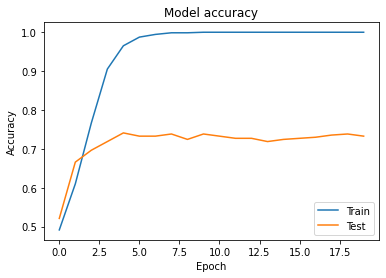

In [74]:
# training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test', 'Classes'], loc='lower right')
plt.show()

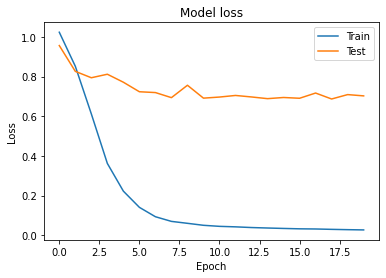

In [75]:
# training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()